# Malaria Cell Image Datasets (Binary Image Classification)

In [1]:
import numpy as np #linear algebra

import os
print(os.listdir("cell-images-for-detecting-malaria/cell_images/train/"))

['Parasitized', 'Uninfected']


In [2]:
import cv2 
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image

In [3]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

In [4]:
img_dir='cell-images-for-detecting-malaria/cell_images/train/'

In [5]:
parasitized_data = os.listdir(img_dir + 'Parasitized/')
print(parasitized_data[:5]) #the output we get are the .png files

uninfected_data = os.listdir(img_dir + 'Uninfected/')
print('\n')
print(uninfected_data[:5])

['C175P136NThinF_IMG_20151127_142009_cell_212.png', 'C115P76ThinF_IMG_20150930_163018_cell_252.png', 'C84P45ThinF_IMG_20150818_101146_cell_100.png', 'C82P43ThinF_IMG_20150817_123652_cell_212.png', 'C51AP12thinF_IMG_20150724_154330_cell_122.png']


['C172P133ThinF_IMG_20151119_155343_cell_38.png', 'C62P23N_ThinF_IMG_20150818_133307_cell_141.png', 'C105P66ThinF_IMG_20150924_095913_cell_65.png', 'C134P95ThinF_IMG_20151005_121834_cell_7.png', 'C51AP12thinF_IMG_20150724_154243_cell_19.png']


# Data Visualization

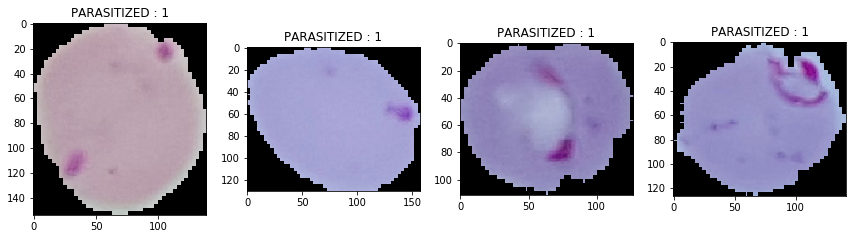

In [6]:
#Parasitized

plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(img_dir + 'Parasitized/' + parasitized_data[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()

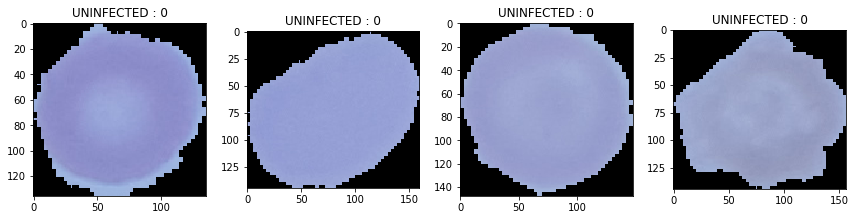

In [7]:
#Uninfected

plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(img_dir + 'Uninfected/' + uninfected_data[i+1])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

# Defining basic transformation for raw data

In [8]:
# Define your transforms for the training and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

In [9]:
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)

In [10]:
train_data

Dataset ImageFolder
    Number of datapoints: 27558
    Root Location: cell-images-for-detecting-malaria/cell_images/train/
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-30, 30), resample=False, expand=False)
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomVerticalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

# Splitting datasets into training and testing sets

In [11]:
# number of subprocesses to use for data loading
num_workers = 0

test_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
test_split = int(np.floor((test_size) * num_train))
test_idx, train_idx = indices[:test_split], indices[test_split:]

print(len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=20, 
    sampler=test_sampler, num_workers=num_workers)

5511 22047


# Building CNN model

In [12]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        temp_dim = 16 * 53 * 53
        self.fc1 = nn.Linear(temp_dim, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(x))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
classifier = ImageClassifier()    

In [13]:
print(classifier)

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


# Defining loss function and backpropagation

In [14]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    classifier = classifier.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001 , momentum=0.9)

# Training the network

In [15]:
def train(n_epochs, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))

            
    # return trained model
    return model

In [16]:
train(15, classifier, optimizer, criterion, use_cuda, 'malaria_detection.pt')

# Testing the model

In [17]:
def test(model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
test(classifier, criterion, use_cuda)

"def test(model, criterion, use_cuda):\n\n    # monitor test loss and accuracy\n    test_loss = 0.\n    correct = 0.\n    total = 0.\n\n    for batch_idx, (data, target) in enumerate(test_loader):\n        # move to GPU\n        if use_cuda:\n            data, target = data.cuda(), target.cuda()\n        # forward pass: compute predicted outputs by passing inputs to the model\n        output = model(data)\n        # calculate the loss\n        loss = criterion(output, target)\n        # update average test loss \n        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))\n        # convert output probabilities to predicted class\n        pred = output.data.max(1, keepdim=True)[1]\n        # compare predictions to true label\n        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())\n        total += data.size(0)\n            \n    print('Test Loss: {:.6f}\n'.format(test_loss))\n\n    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (\n    

# Visualizing model predictions

In [18]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [19]:
def predict_malaria(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

Parasitized


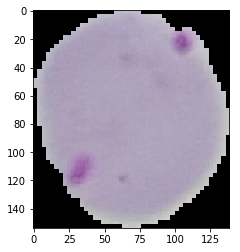

Parasitized


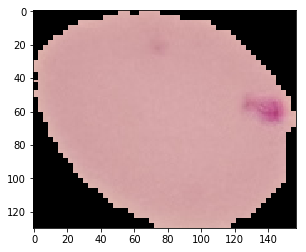

Parasitized


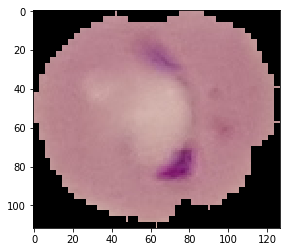

Uninfected


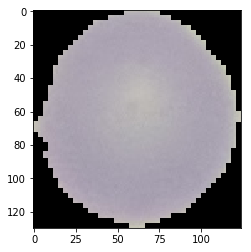

Uninfected


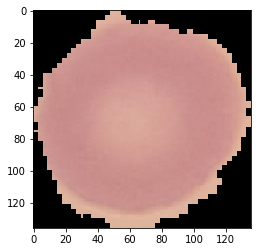

Uninfected


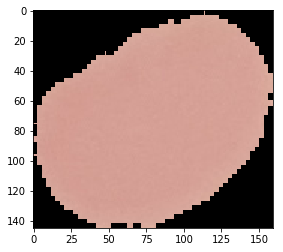

In [21]:
from glob import glob
from PIL import Image
from termcolor import colored

class_names=['Parasitized','Uninfected']

inf = np.array(glob("cell-images-for-detecting-malaria/cell_images/train/Parasitized/*"))
uninf = np.array(glob("cell-images-for-detecting-malaria/cell_images/train/Uninfected/*"))

for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    if predict_malaria(classifier, class_names, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
    plt.imshow(img)
    plt.show()
    
for i in range(3):
    img_path=uninf[i]
    img = Image.open(img_path)
    if predict_malaria(classifier, class_names, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))        
    plt.imshow(img)
    plt.show()

# Saving model

In [ ]:
torch.save(classifier.state_dict(), 'malaria_classification.pt')

In [20]:
classifier.load_state_dict(torch.load('malaria_classification.pt'))